In [2]:
import sqlalchemy
import pandas as pd
from sqlalchemy import text
import requests
from datetime import datetime, date
import datetime
import sqlite3
import pymysql as mysql
import matplotlib.pyplot as plt

In [7]:
# Constant values/database information
PORT = 3306
HOST_NAME = "nycdb.mysql.database.azure.com"
USERNAME = "lvandine"
PASSWORD = "N33dN3w0n3!"
DATABASE = "nycdb"

# Validate the Data
def check_if_empty(df: pd.DataFrame, primaryKey) -> bool:
    # Check if the dataframe is empty
    if df.empty:
        print("No information in the dataframe")
        return False
    return True


# Extract the Data
if __name__ == "__main__":

    # Convert the csv data to a structured dataframe

    # Extract the raw data
    collision_data = pd.read_csv('C:/Users/lvand/OneDrive/Desktop/Practical_Data_Engineering/Group/database.csv', parse_dates =['DATE'])
    uber_data = pd.read_csv('C:/Users/lvand/OneDrive/Desktop/Practical_Data_Engineering/Group/Uber_Trips_NYC_2016.csv', parse_dates =['Pickup Start Date', 'Pickup End Date'])
    weather_data = pd.read_csv('C:/Users/lvand/OneDrive/Desktop/Practical_Data_Engineering/Group/NYC_Central_Park_weather_1869-2022.csv', parse_dates =['DATE'])

    # Changing the spaces in the names to underscores for use in sql statements
    collision_data.columns = collision_data.columns.str.replace(' ', '_')
    uber_data.columns = uber_data.columns.str.replace(' ', '_')
    weather_data.columns = weather_data.columns.str.replace(' ', '_')

    # Dropping nulls in the weather_data and replacing them with 0s in other places
    weather_data.dropna(subset = ['TMIN'], inplace=True)
    weather_data.reset_index()
    weather_data['SNOW'].fillna(0, inplace=True)
    weather_data['SNWD'].fillna(0, inplace=True)

    # Create a database connection
    engine = sqlalchemy.create_engine(f"mysql+pymysql://{USERNAME}:{PASSWORD}@{HOST_NAME}:{PORT}/{DATABASE}")
    conn = engine.connect()

    # Create tables with DDL
    ddl1 = """
    CREATE TABLE IF NOT EXISTS `Daily_Weather` (
        `day_id` INT PRIMARY KEY AUTO_INCREMENT,
        `date` DATE NOT NULL,
        `prcp` DOUBLE NULL DEFAULT NULL,
        `snow` DOUBLE NULL DEFAULT NULL,
        `snwd` DOUBLE NULL DEFAULT NULL,
        `tmin` INT NOT NULL,
        `tmax` INT NOT NULL
    );
    """


    ddl2 = """
    CREATE TABLE IF NOT EXISTS `Collisions` (
        `collision_id` INT NOT NULL PRIMARY KEY AUTO_INCREMENT,
        `day_id` INT NOT NULL,
	    `unique_key` INT NOT NULL,
	    `date` DATE NOT NULL,
	    `time` TEXT NOT NULL,
	    `borough` VARCHAR(45) NULL DEFAULT NULL,
	    `zip_code` VARCHAR(5) NULL DEFAULT NULL,
	    `latitude` TEXT NULL DEFAULT NULL,
	    `longitude` TEXT NULL DEFAULT NULL,
	    `location` VARCHAR(45) NULL DEFAULT NULL,
	    `on_street_name` VARCHAR(60) NULL DEFAULT NULL,
	    `cross_street_name` VARCHAR(60) NULL DEFAULT NULL,
	    `off_street_name` VARCHAR(60) NULL DEFAULT NULL,
	    `persons_injured` INT NOT NULL,
	    `persons_killed` INT NOT NULL,
	    `pedestrians_injured` INT NOT NULL,
	    `pedestrians_killed` INT NOT NULL,
	    `cyclists_injured` INT NOT NULL,
	    `cyclists_killed` INT NOT NULL,
	    `motorists_injured` INT NOT NULL,
	    `motorists_killed` INT NOT NULL,
	    `vehicle_1_type` VARCHAR(60) NULL DEFAULT NULL,
	    `vehicle_2_type` VARCHAR(60) NULL DEFAULT NULL,
	    `vehicle_3_type` VARCHAR(60) NULL DEFAULT NULL,
	    `vehicle_4_type` VARCHAR(60) NULL DEFAULT NULL,
	    `vehicle_5_type` VARCHAR(60) NULL DEFAULT NULL,
	    `vehicle_1_factor` VARCHAR(60) NULL DEFAULT NULL,
	    `vehicle_2_factor` VARCHAR(60) NULL DEFAULT NULL,
	    `vehicle_3_factor` VARCHAR(60) NULL DEFAULT NULL,
	    `vehicle_4_factor` VARCHAR(60) NULL DEFAULT NULL,
	    `vehicle_5_factor` VARCHAR(60) NULL DEFAULT NULL,
	    FOREIGN KEY (`day_id`) REFERENCES `Daily_Weather`(`day_id`)
    );
    """

    ddl3 = """
    CREATE TABLE IF NOT EXISTS `Uber` (
        `ride_id` INT NOT NULL PRIMARY KEY AUTO_INCREMENT,
        `start_day_id` INT NOT NULL,
        `end_day_id` INT NOT NULL,
        `base_license_number` VARCHAR(7) NOT NULL,
        `wave_number` INT NOT NULL,
        `base_name` VARCHAR(45) NOT NULL,
        `dba` VARCHAR(45) NOT NULL,
        `years` INT NOT NULL,
        `week_number` INT NOT NULL,
        `pickup_start_date` DATE NOT NULL,
        `pickup_end_date` DATE NOT NULL,
        `total_dispatched_trips` INT NOT NULL,
        `unique_dispatched_vehicle` INT NOT NULL,
        FOREIGN KEY (`start_day_id`) REFERENCES `Daily_Weather`(`day_id`),
        FOREIGN KEY (`end_day_id`) REFERENCES `Daily_Weather`(`day_id`)
    );
    """
    # Validate the data sets
    if check_if_empty(weather_data, "date"):
        print("Weather data valid, checking Collision data")
    if check_if_empty(collision_data, "uniq_key"):
        print("Collision data valid, checking Uber data")
    if check_if_empty(uber_data, "collision_id"):
        print("Uber data valid, proceed to creating the database")

    # Execute the sql query and create the table above
    conn.execute(text(ddl1))
    conn.execute(text(ddl2))
    conn.execute(text(ddl3))
    print("Successfully created the database")

    # populating the weather table
    weather_data.to_sql(name = "daily_weather",con = engine, if_exists= "append", index=False)
    print("Finished populating daily_weather table")

   # had to add this part in because at the time of table creation, this table doesnt know the day_id of the weather table
    weather_data['day_id'] = list(map(lambda x: x, range(1,weather_data.shape[0]+1)))
    tempdf= pd.merge(weather_data, collision_data, on= ['DATE'], how = 'inner')
    dayid_col = tempdf.pop('day_id')
    collision_data.insert(0,'day_id',dayid_col)

    # populating the collisions table
    collision_data.to_sql(name = "collisions", con = engine, if_exists="append", index=False)
    print("Finished populating collisions table")

    # had to add this part in because at the time of table creation, this table doesnt know the day_id of the weather table
    # first getting the day_id for the pickup start date 
    temp_df1 = uber_data.rename(mapper = {"Pickup_Start_Date":"DATE"}, axis = 1)
    temp_df1 = pd.merge(weather_data, temp_df1, on = ['DATE'], how = 'right')
    uber_data.insert(0, 'start_day_id', temp_df1['day_id'])

    # now getting the day_id for the pickup end date 
    temp_df2 = uber_data.rename(mapper = {"Pickup_End_Date":"DATE"}, axis = 1)
    temp_df2 = pd.merge(weather_data, temp_df2, on = ['DATE'], how = 'right')
    uber_data.insert(1, 'end_day_id', temp_df2['day_id'])

    # populating the uber table
    uber_data.to_sql(name = "uber", con = engine, if_exists="append", index=False)
    print("Finished populating uber table")

    transform_collision1 = """
    CREATE VIEW tranform_collision1
    AS
    SELECT *
    FROM Collisions
    WHERE YEAR(`date`) = 2016;
    """
    transform_uber1 = """
    CREATE VIEW transform_uber1
    AS
    SELECT *
    FROM Uber
    WHERE YEAR(`pickup_start_date`) = 2016;
    """
    transform_weather1 = """
    CREATE VIEW transform_weather1
    AS
    SELECT *
    FROM Daily_Weather
    WHERE YEAR(`date`) = 2016;
    """

    conn.execute(text(transform_collision1))
    conn.execute(text(transform_uber1))
    conn.execute(text(transform_weather1))

    print("Data was tranformed to show columns from 2016")
     Close the database connection
    conn.close()
    print("Connection closed")


Weather data valid, checking Collision data
Collision data valid, checking Uber data
Uber data valid, proceed to creating the database
Successfully created the database
Finished populating daily_weather table
Finished populating collisions table
Finished populating uber table
Connection closed


In [34]:
# SQL query to fetch data from the view to use for Python physical output
sql_query1 = "SELECT * FROM transform_weather1;"
sql_query2 = "SELECT * FROM tranform_collision1;"
sql_query3 = "SELECT * FROM transform_uber1;"

# Execute the SQL query and load data into a DataFrame
weatherdf = pd.read_sql_query(sql_query1, engine)
collisiondf = pd.read_sql_query(sql_query2, engine)
uberdf = pd.read_sql_query(sql_query3, engine)

# Convert the 'date' column to datetime format
weatherdf['date'] = pd.to_datetime(weatherdf['date'])
collisiondf['date'] = pd.to_datetime(collisiondf['date'])
uberdf['pickup_start_date'] = pd.to_datetime(uberdf['pickup_start_date'])


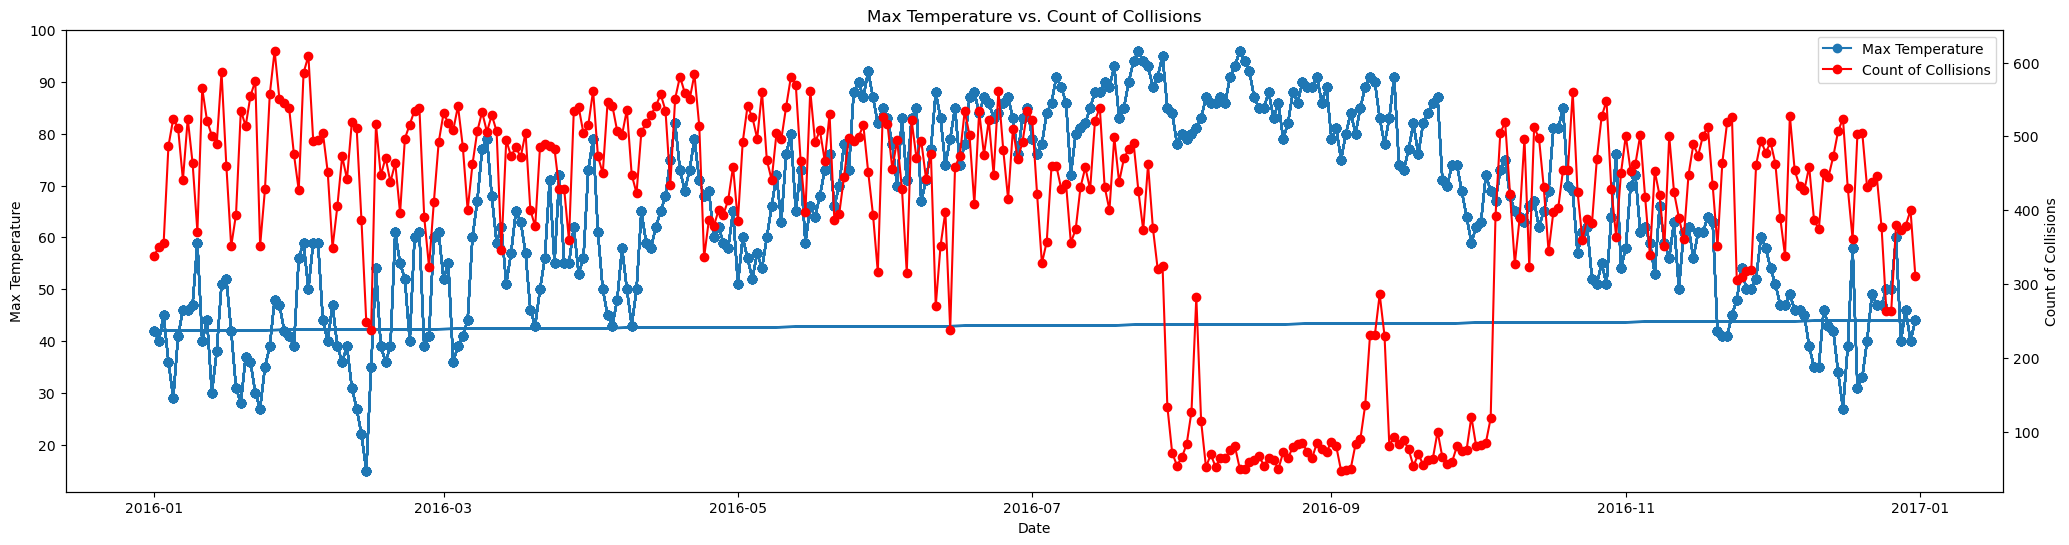

In [33]:
# Count occurences of variable for plotting
count_by_date = collisiondf.groupby('date')['latitude'].nunique().reset_index(name='count')

# Create visualization
fig, ax1 = plt.subplots(figsize=(25, 6))

# Plot variables from different DataFrames on the left y-axis
line1, = ax1.plot(weatherdf['date'], weatherdf['tmax'], marker='o', linestyle='-', label='Max Temperature')
ax1.set_xlabel('Date')
ax1.set_ylabel('Max Temperature', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Create a secondary y-axis on the right side for the count of collisions
ax2 = ax1.twinx()
line2, = ax2.plot(count_by_date['date'], count_by_date['count'], marker='o', linestyle='-', label='Count of Collisions', color='red')
ax2.set_ylabel('Count of Collisions', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add legend for each line
ax1.legend([line1, line2], ['Max Temperature', 'Count of Collisions'], loc='upper right')

# Add title to the graph
plt.title('Max Temperature vs. Count of Collisions')

# Show the plot
plt.show()